# Imports

In [53]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline

# Data

## Data Exploration

In [2]:
df = pd.read_csv("Data/celldata.csv")

In [3]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
0,632,Germany,Female,50,5,107959.39,1,1,1,6985,1
1,649,France,Female,42,7,0.00,2,0,1,22974,0
2,595,France,Male,29,6,150685.79,1,1,0,87771,0
3,653,Spain,Male,35,6,116662.96,2,1,1,23864,0
4,559,Spain,Female,40,7,144470.77,1,1,1,18918,0


In [4]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Salary', 'Churn'],
      dtype='object')

In [5]:
df.dtypes

CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure              int64
Balance           float64
NumOfProducts       int64
HasCrCard           int64
IsActiveMember      int64
Salary              int64
Churn               int64
dtype: object

In [9]:
set(df["Geography"].values)

{'France', 'Germany', 'Spain'}

In [10]:
set(df['Gender'].values)

{'Female', 'Male'}

In [11]:
df = pd.get_dummies(df, columns=["Gender"], prefix="Gender")

In [12]:
df

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn,Gender_Female,Gender_Male
0,632,Germany,50,5,107959.39,1,1,1,6985,1,True,False
1,649,France,42,7,0.00,2,0,1,22974,0,True,False
2,595,France,29,6,150685.79,1,1,0,87771,0,False,True
3,653,Spain,35,6,116662.96,2,1,1,23864,0,False,True
4,559,Spain,40,7,144470.77,1,1,1,18918,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,560,France,44,5,143244.97,1,1,0,98661,0,True,False
7996,410,France,33,6,125789.69,1,0,0,66334,1,False,True
7997,610,France,36,4,129440.30,2,1,0,102638,0,False,True
7998,490,France,33,1,0.00,2,1,1,80793,0,False,True


In [ ]:
encoder = OneHotEncoder(drop=None, sparse_output=False)

encoded = encoder.fit_transform(df[["Geography"]])

encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out(["Geography"])
)

df_encoded = pd.concat([df.drop(columns=["Geography"]), encoded_df], axis=1)

In [15]:
df_encoded

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,632,50,5,107959.39,1,1,1,6985,1,True,False,0.0,1.0,0.0
1,649,42,7,0.00,2,0,1,22974,0,True,False,1.0,0.0,0.0
2,595,29,6,150685.79,1,1,0,87771,0,False,True,1.0,0.0,0.0
3,653,35,6,116662.96,2,1,1,23864,0,False,True,0.0,0.0,1.0
4,559,40,7,144470.77,1,1,1,18918,0,True,False,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,560,44,5,143244.97,1,1,0,98661,0,True,False,1.0,0.0,0.0
7996,410,33,6,125789.69,1,0,0,66334,1,False,True,1.0,0.0,0.0
7997,610,36,4,129440.30,2,1,0,102638,0,False,True,1.0,0.0,0.0
7998,490,33,1,0.00,2,1,1,80793,0,False,True,1.0,0.0,0.0


<Axes: >

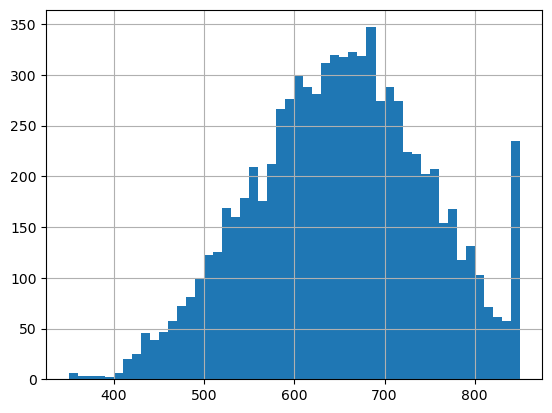

In [17]:
df['CreditScore'].hist(bins=50)

<Axes: >

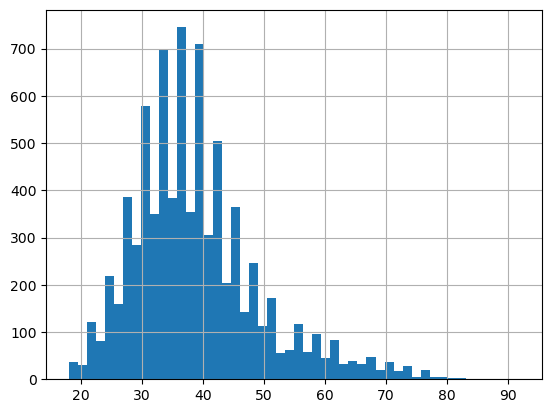

In [20]:
df['Age'].hist(bins=50)

<Axes: >

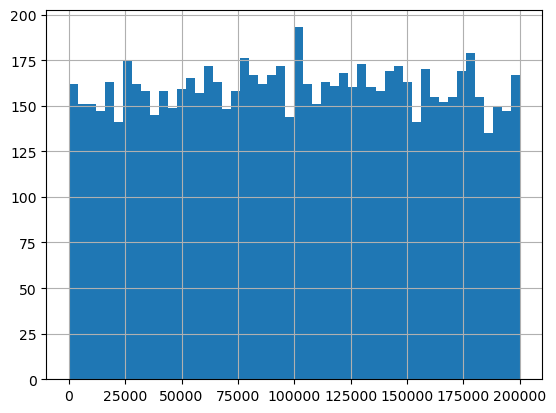

In [22]:
df['Salary'].hist(bins=50)

<Axes: >

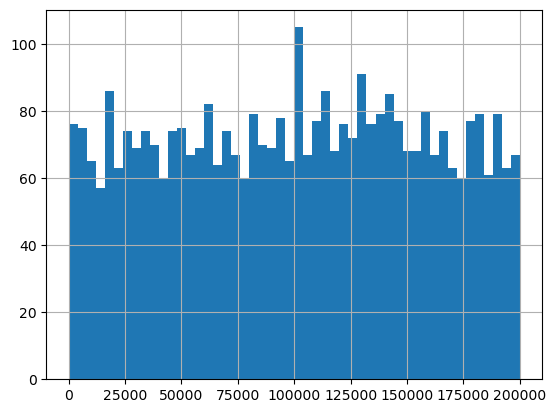

In [24]:
df[df['Gender_Female']==True]['Salary'].hist(bins=50)

<Axes: >

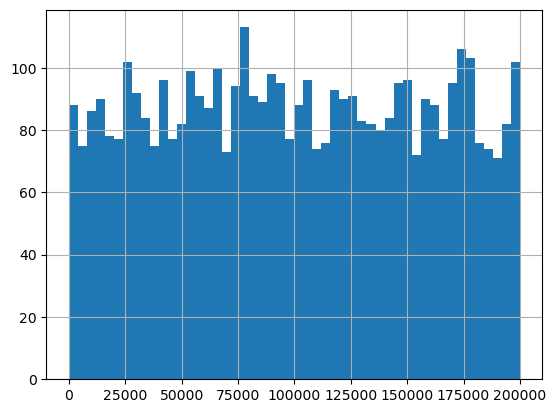

In [25]:
df[df['Gender_Male']==True]['Salary'].hist(bins=50)

<Axes: >

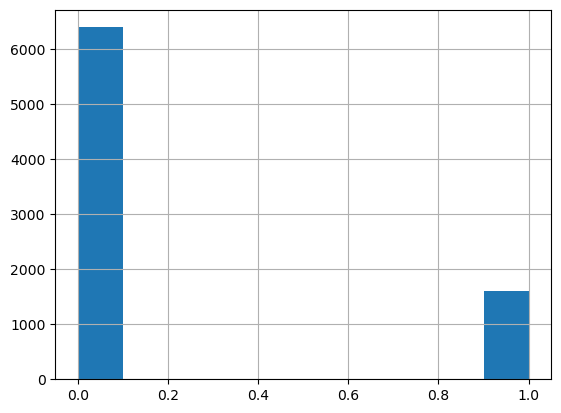

In [27]:
df['Churn'].hist()

In [29]:
df_encoded.dtypes

CreditScore            int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
Salary                 int64
Churn                  int64
Gender_Female           bool
Gender_Male             bool
Geography_France     float64
Geography_Germany    float64
Geography_Spain      float64
dtype: object

## Weighting the churn to avoid false prediction

In [31]:
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

In [32]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
print(dict(zip(np.unique(y), class_weights)))

{0: 0.6258801439524331, 1: 2.4860161591050343}


In [35]:
weights = np.array([class_weights[y_i] for y_i in y])

# Testing different models

## Naive Bayes

### Simple implementation

In [46]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test, w_train, w_test= train_test_split(X, y, weights, test_size=0.2,random_state=42)

model = GaussianNB()
model.fit(X_train,y_train, sample_weight=w_train)
y_pred = model.predict(X_test)

In [47]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.7075
0.3802083333333333
0.6636363636363637
0.48344370860927155


In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1270
           1       0.38      0.66      0.48       330

    accuracy                           0.71      1600
   macro avg       0.64      0.69      0.64      1600
weighted avg       0.79      0.71      0.73      1600



### Cross Validation procedure

In [49]:
kf = KFold(n_splits=5)

kf.get_n_splits(X)

scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {key: [] for key in scoring.keys()}

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    w_train = weights[train_idx]

    # Modèle Naive Bayes avec pondération
    model = GaussianNB()
    model.fit(X_train, y_train, sample_weight=w_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # nécessaire pour roc_auc

    # Calcul des scores
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['auc'].append(roc_auc_score(y_test, y_proba))
    results['f1'].append(f1_score(y_test, y_pred))
    results['precision'].append(precision_score(y_test, y_pred))
    results['recall'].append(recall_score(y_test, y_pred))

# Moyennes sur les folds
for metric in results:
    print(f"{metric}: {np.mean(results[metric]):.4f}")

accuracy: 0.7103
auc: 0.7392
f1: 0.4743
precision: 0.3740
recall: 0.6496


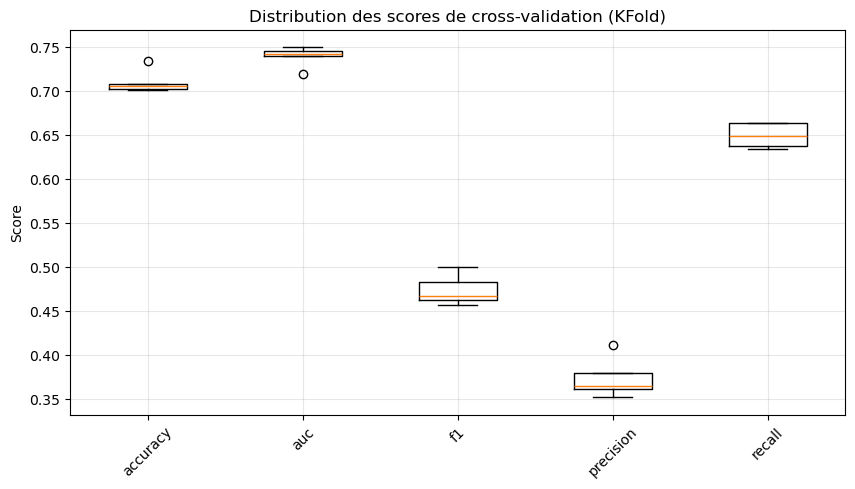

In [50]:
keys = list(results.keys())
values = [results[key] for key in keys]

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.title("Distribution des scores de cross-validation (KFold)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

### Standardisation + Cross Validation

In [59]:
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler', StandardScaler()),
    ('gaussiannb', GaussianNB())
])

model.fit(X_train, y_train, gaussiannb__sample_weight=w_train)
y_pred = model.predict(X_test)


In [60]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1266
           1       0.41      0.67      0.50       334

    accuracy                           0.73      1600
   macro avg       0.65      0.70      0.66      1600
weighted avg       0.79      0.73      0.75      1600



In [61]:
confusion_matrix(y_test,y_pred)

array([[939, 327],
       [111, 223]])

In [63]:
y_score = model.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_score)
auc(fpr,tpr)

0.7791263526173333

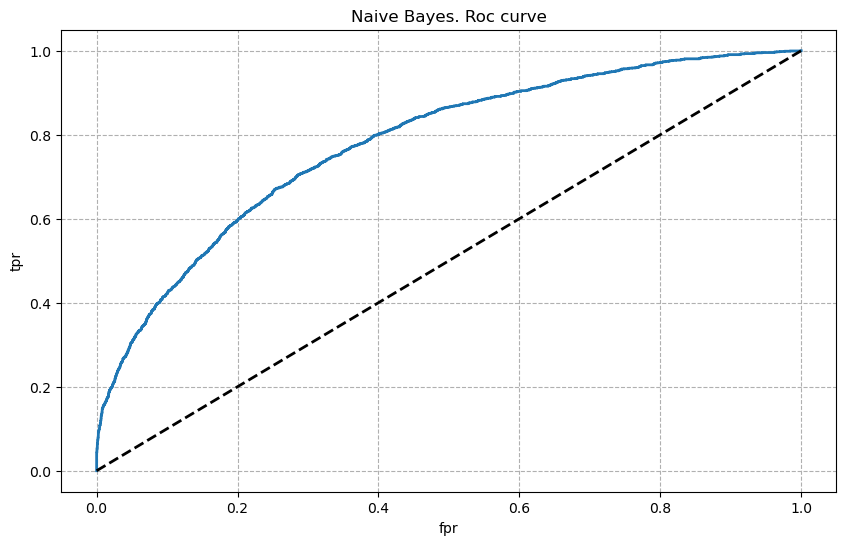

In [64]:
y_proba= model.predict_proba(X)[:,1];
fpr, tpr, thresholds= roc_curve(y, y_proba);
figure= plt.figure(figsize=(10,6));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Naive Bayes. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed') 
plt.show()

## Linear Discriminant Analysis